In [84]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

df = pd.read_csv("Crime_Data_from_2020_to_Present.csv", converters={'TIME OCC': str}, index_col=False)

df["DATE OCC"] = pd.to_datetime(df["DATE OCC"].str.split(" ").str[0] + df["TIME OCC"], format='%m/%d/%Y%H%M')
df["Date Rptd"] = pd.to_datetime(df["Date Rptd"].str.split(" ").str[0], format='%m/%d/%Y')
df.drop(['DR_NO', 'TIME OCC', 'Part 1-2', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Status', 'Status Desc', 'Cross Street', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Mocodes'], axis=1, inplace=True)

df = df.sort_values(by=["DATE OCC"]).reset_index(drop=True)

import datetime as dt

years = [2020, 2022, 2023]

crime_years = [df[df["DATE OCC"].dt.year == y] for y in years]
print(len(crime_years))

temp = pd.concat([crime_years[0], crime_years[1]])
crime_final = pd.concat([temp, crime_years[2]])

3


In [86]:
crime_final = crime_final[(crime_final["LON"] != 0) & (crime_final["LAT"] != 0)]

In [87]:
# Obliczanie estymatora wariancji j-tej współrzędnej: x -> wartości losowe, m -> liczba wartości


def calculate_Vj(x, m):
  sum_1 = 0.0
  sum_2 = 0.0

  for i in range(m):
    sum_1 += x[i]**2
    sum_2 += x[i]

  return   (1. / (m - 1)) * sum_1 - (1. / (m*(m - 1))) * sum_2**2

# Czwarta pochodna funkcji K
def K_4(x):
  return (1. / np.sqrt(2*np.pi)) * (np.power(x, 4) - 6*np.power(x, 2) + 3) * np.exp(-x ** 2 / 2.)

# Szósta pochodna funkcji K
def K_6(x):
  return (1. / np.sqrt(2*np.pi)) * (np.power(x , 6.) - 15*np.power(x, 4) + 45*np.power(x, 2) - 15) * np.exp(-x ** 2 / 2.)


# Obliczanie współczynnika C: x -> wartości losowe, m -> liczba wartości, h -> współczynnik h (inny niż ten co mamy ostatecznie policzyć),
#                             xi -> współczynnik xi (ten taki grecki zawijas), K_n -> n-ta pochodna funkcji K

def calculate_C(x, m, h, xi, K_n):

  sum = 0.
  for i in range(m):
    for j in range(m):
      sum += K_n(((x[i] - x[j]) / h))

  return (1. / (m**2 * np.power(h, xi + 1.))) * sum

# Obliczanie parametru wygładzania h: x -> zbiór wartości, m -> liczba wartości, h -> współczynnik h (inny niż ten co mamy ostatecznie policzyć),
#                                     xi -> współczynnik xi (ten taki grecki zawijas), K -> funkcja K, x0 -> przesunięcie funkcji K o stałe

def calculate_h(x, m):

  #1. Obliczamy estymator wariancji
  V = calculate_Vj(x, m)

  #2. Obliczamy estymator odchylenia standardowego
  sigma = np.sqrt(V)

  #3. Obliczamy wartośc c8
  c8 = 105. / (32. * np.sqrt(np.pi) * np.power(sigma, 9))

  #4. Obliczamy wartość hII
  #K6_0 -> szósta pochodna K w x = 0
  K6_0 = K_6(0.)

  Uk = 1.
  hII = np.power(((-2 * K6_0) / (Uk * c8 * m)), 1 / 9.)

  #5. Obliczamy wartość C6_h11
  C6_hII = calculate_C(x, m, hII, 6., K_6)

  #6. Obliczamy wartość hI, K4_0 -> wartość czwartej pochodnej K w punkcie 0
  K4_0 = K_4(0.)

  hI = np.power(((-2. * K4_0) / (Uk * C6_hII * m)), 1. / 7)

  #7. Obliczamy wartość C4_hI
  C4_hI = calculate_C(x, m, hI, 4., K_4)


  #8. Obliczamy h0, wiedząc że Z(f) = C4_hI
  Wk = 1. / (2 * np.sqrt(np.pi))
  h0 = np.power((Wk / (Uk ** 2 * C4_hI * m)), 1 / 5.)

  return h0

In [88]:
def plot_histogram(random_nums, lower_bound, upper_bound, num_bins = 10, size = 1000, move = 0.5, hist = False):

  fig, axes = plt.subplots(figsize=(12, 5))
  if not hist:
    hist_10, be_10 = np.histogram(random_nums, bins=num_bins, density=True)
    axes.scatter(be_10[1:] - move, hist_10, color='red', marker='_', s=size, linewidth=2.5)
  else:
    axes.hist(random_nums, bins=num_bins, density=True, range=(lower_bound, upper_bound), color='red', histtype='step')
  axes.set_title(f'Histogram dla {len(random_nums)} wartości')
  axes.set_xticks(np.arange(0, upper_bound, 1.0))
  axes.set_yticks(np.arange(0,0.6, 0.1))
  axes.set_xlabel('x')
  axes.set_ylabel('y')
  axes.grid(True)

#### Bierzemy 1000 rekordów z jednej z kategorii przestępstw, zw. na długie czasy obliczeń.

In [89]:
crimes_categories_names = ["Abuse", "Theft", "Fraud", "Property Damage / Theft", "Threats", "Sexual Crimes", "Other Crimes"]
crimes_categories_codes = [[110, 113, 230, 231, 235, 236, 237, 250, 251, 434, 435, 436, 622, 623, 624, 625, 626, 627, 870, 910, 920, 921, 922, 943],
                           [210, 220, 310, 320, 330, 331, 341, 343, 347, 349, 350, 351, 352, 353, 354, 410, 420, 421, 433, 440, 441, 442, 443, 444, 446, 450, 451, 452, 470, 471, 473, 474, 475],
                           [649, 651, 652, 653, 654, 660, 662, 664, 666, 668, 670, 942, 950, 951],
                           [647, 648, 740, 745, 888, 433, 438, 480, 485, 487, 510, 520, 522],
                           [940, 753, 755, 756, 763, 928, 933, 930],
                           [760, 762, 805, 806, 810, 812, 813, 814, 815, 820, 821, 822, 845, 850, 932, 956, 121, 122, 860],
                           [437, 439, 661, 761, 880, 886, 890, 900, 901, 902, 903, 906, 931, 944, 946, 949, 954, 865]]

In [90]:
def split_crime_by_code(df):
    split_crimes = {}

    for i in range(len(crimes_categories_names)):
        split_crimes[crimes_categories_names[i]] = df[df['Crm Cd'].isin(crimes_categories_codes[i])].reset_index()
    
    return split_crimes

def split_crimes_by_year(split: dict):
    years = [2020, 2022, 2023]
    
    res = []

    for year in years:
        temp = {}
        for label in split.keys():
            temp[label] = split[label][split[label]['DATE OCC'].dt.year == year]
        res.append(temp)
    
    return res


split = split_crime_by_code(crime_final)
split_years = split_crimes_by_year(split)

In [91]:
display(split_years[0]['Abuse'])

,index,Date Rptd,DATE OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LOCATION,LAT,LON
0,17,2020-08-10,2020-01-01 00:01:00,4,Hollenbeck,429,626,INTIMATE PARTNER - SIMPLE ASSAULT,28,F,H,3700 LOWELL AV,34.0882,-118.1624
1,18,2022-04-16,2020-01-01 00:01:00,20,Olympic,2054,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",45,F,O,900 S NORMANDIE AV,34.0533,-118.3003
2,40,2023-03-15,2020-01-01 00:01:00,13,Newton,1364,626,INTIMATE PARTNER - SIMPLE ASSAULT,42,F,H,4600 HOOPER AV,33.9994,-118.2543
3,57,2020-09-02,2020-01-01 00:01:00,12,77th Street,1265,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,6,M,H,8200 S VERMONT AV,33.9655,-118.2918
4,61,2020-08-21,2020-01-01 00:01:00,17,Devonshire,1764,626,INTIMATE PARTNER - SIMPLE ASSAULT,33,F,H,9600 CORBIN AV,34.2446,-118.5623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46087,199777,2021-01-01,2020-12-31 23:40:00,15,N Hollywood,1555,625,OTHER ASSAULT,43,M,O,11100 OTSEGO ST,34.1630,-118.3709
46088,199781,2021-01-04,2020-12-31 23:50:00,15,N Hollywood,1532,624,BATTERY - SIMPLE ASSAULT,25,M,H,12300 OXNARD ST,34.1794,-118.4009
46089,199782,2020-12-31,2020-12-31 23:50:00,18,Southeast,1829,626,INTIMATE PARTNER - SIMPLE ASSAULT,24,F,H,97TH ST,33.9483,-118.2290
46090,199783,2020-12-31,2020-12-31 23:55:00,5,Harbor,504,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",24,M,H,TORRANCE,33.8416,-118.3040


In [92]:
def k(x, x0 = 0., h = 1.):
    return 1/np.sqrt(2*np.pi) * np.exp(-((x-x0)/h)**2/2)

def gauss_calc(x, x0, m, K = k, h=1.0):
  result = K(x, x0[0])
  for i in range(1, m):
    result += K(x, x0[i], h)
  result = result/(float(m)*h)
  return result

def convert_date_to_numbers(tab):
  min_date = np.min(tab)

  for i in range(len(tab)):
    tab[i] = float((tab[i] - min_date).days)

  return tab

def gauss_calc_df(split, category, m, K = k, h = 1.):
  temp = split[category].copy()
  temp = temp.sample(n=m, random_state=12)

  extract_columns = ['DATE OCC', 'LAT', 'LON']
  temp['DATE OCC'] = temp['DATE OCC'].dt.date


  x_tab = []
  gauss_res = []
  gauss_to_original = {}
  for extract in extract_columns:
    column = temp[extract].copy().to_numpy()
    copy = column.copy()
    if extract == 'DATE OCC':
      column = convert_date_to_numbers(column)
  
    x = np.linspace(np.min(column), np.max(column), m)
    gauss = gauss_calc(x, column, m=m)
    gauss_res.append(gauss)
    gauss_to_original[extract] = dict(zip(gauss, copy))
    x_tab.append(x)

  return gauss_res, x_tab, gauss_to_original, temp

In [93]:
test_sample, x_tab, _, _ = gauss_calc_df(split_years[0], 'Abuse', 1000)

In [94]:
print(test_sample[0])

[0.00310682 0.00309513 0.00283047 0.00247804 0.00221665 0.00215805
 0.00231206 0.00260158 0.00290739 0.00311938 0.00317755 0.0030919
 0.00293504 0.00280762 0.00278882 0.00289657 0.00308106 0.0032552
 0.00334141 0.00330697 0.0031718  0.00298987 0.00281765 0.00268765
 0.00260111 0.00253984 0.00248339 0.00241589 0.00232161 0.00218298
 0.00199223 0.00176908 0.00156392 0.00143549 0.00141709 0.00149827
 0.00163591 0.00178321 0.00191346 0.00202461 0.00212724 0.00222786
 0.00231906 0.00238178 0.0023976  0.00236188 0.00228817 0.00220097
 0.00212335 0.00206864 0.00204038 0.00203802 0.00206248 0.00211738
 0.00220485 0.00231788 0.00243362 0.00251286 0.00250823 0.00238043
 0.00211693 0.00174479 0.00132874 0.0009528  0.00069403 0.00060262
 0.0006957  0.00096052 0.00135804 0.00182518 0.00228257 0.00265478
 0.00289881 0.00302538 0.00309711 0.00319899 0.00339093 0.00366602
 0.00394319 0.00410918 0.00409011 0.00390383 0.00365299 0.00346452
 0.00342017 0.0035213  0.00369892 0.00385141 0.00388652 0.003752

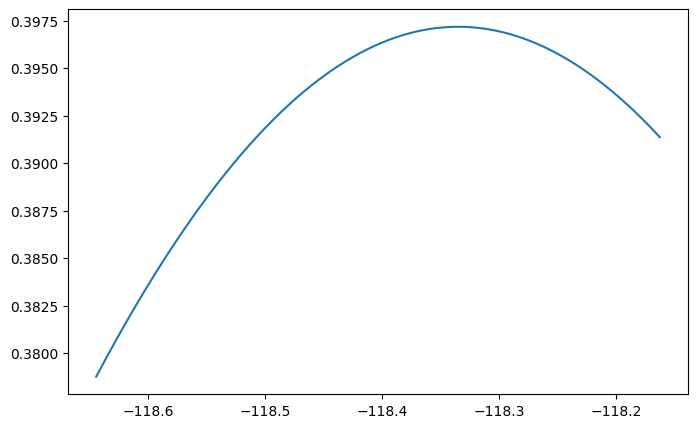

In [95]:
def plot_gauss(fun, fun_range):
    fig = plt.figure(figsize = (8,5))
    plt.plot(fun_range, fun)
    # plt.yticks(np.arange(0,0.55,0.1))
    plt.show()



plot_gauss(test_sample[2], x_tab[2])

In [96]:
def calculate_h_for_features(samples, m):
    x = np.arange(0, m)
    new_hs = []
    for sample in samples:
        new_h = calculate_h(sample, m)
        sample = gauss_calc(x, sample, m, h=new_h)

        new_hs.append(new_h)
    
    return samples, new_hs
    
test_sample, hs = calculate_h_for_features(test_sample, 1000)

print(test_sample)

[array([0.00310682, 0.00309513, 0.00283047, 0.00247804, 0.00221665,
       0.00215805, 0.00231206, 0.00260158, 0.00290739, 0.00311938,
       0.00317755, 0.0030919 , 0.00293504, 0.00280762, 0.00278882,
       0.00289657, 0.00308106, 0.0032552 , 0.00334141, 0.00330697,
       0.0031718 , 0.00298987, 0.00281765, 0.00268765, 0.00260111,
       0.00253984, 0.00248339, 0.00241589, 0.00232161, 0.00218298,
       0.00199223, 0.00176908, 0.00156392, 0.00143549, 0.00141709,
       0.00149827, 0.00163591, 0.00178321, 0.00191346, 0.00202461,
       0.00212724, 0.00222786, 0.00231906, 0.00238178, 0.0023976 ,
       0.00236188, 0.00228817, 0.00220097, 0.00212335, 0.00206864,
       0.00204038, 0.00203802, 0.00206248, 0.00211738, 0.00220485,
       0.00231788, 0.00243362, 0.00251286, 0.00250823, 0.00238043,
       0.00211693, 0.00174479, 0.00132874, 0.0009528 , 0.00069403,
       0.00060262, 0.0006957 , 0.00096052, 0.00135804, 0.00182518,
       0.00228257, 0.00265478, 0.00289881, 0.00302538, 0.0030

In [97]:
print(test_sample[2])

[0.37875343 0.37880945 0.3788654  0.37892126 0.37897705 0.37903276
 0.37908839 0.37914394 0.37919941 0.3792548  0.37931011 0.37936534
 0.37942049 0.37947557 0.37953056 0.37958547 0.37964031 0.37969506
 0.37974973 0.37980433 0.37985884 0.37991328 0.37996764 0.38002191
 0.38007611 0.38013022 0.38018426 0.38023821 0.38029209 0.38034588
 0.3803996  0.38045323 0.38050679 0.38056026 0.38061366 0.38066697
 0.38072021 0.38077336 0.38082643 0.38087943 0.38093234 0.38098517
 0.38103792 0.38109059 0.38114318 0.38119569 0.38124812 0.38130046
 0.38135273 0.38140492 0.38145702 0.38150905 0.38156099 0.38161285
 0.38166463 0.38171633 0.38176795 0.38181949 0.38187095 0.38192232
 0.38197362 0.38202483 0.38207596 0.38212701 0.38217798 0.38222887
 0.38227968 0.3823304  0.38238105 0.38243161 0.38248209 0.38253249
 0.38258281 0.38263304 0.3826832  0.38273327 0.38278326 0.38283317
 0.382883   0.38293274 0.3829824  0.38303199 0.38308149 0.3831309
 0.38318024 0.38322949 0.38327866 0.38332775 0.38337676 0.38342

In [98]:
# stwórz wariant do usuwania nietypowych pomiędzy kategoriami, np.: x i y, czas i y, czas i x

def determine_if_typical(r, m, vals, h):
  # gauss_y = gauss_calc(x, random_nums, m, K = k, h=1.0)
  gauss_y = []
  for i in range(m):
    # for j in range(m):
    temp = np.delete(vals, i, axis=0)
    gauss_y.append(gauss_calc(vals[i], temp, m - 1, K = k, h=h))

  typical_arr = {}
  gauss_y = dict(enumerate(gauss_y, 0))

  # q = estimate_q(gauss_y, r, m)
  gauss_y = sorted(gauss_y.items(), key=lambda x:x[1])
  gauss_y = dict(gauss_y)
  gauss_items = list(gauss_y.values())
  q = gauss_items[0 if  m*r < 0.5 else int(m*r + 0.5)]
  for idx, val in gauss_y.items():
    if idx < 1000:
      if val <= q:
        typical_arr[vals[idx]] = 1
      else:
        typical_arr[vals[idx]] = 0
  return typical_arr

In [99]:
def determine_if_typical_for_features(samples, r, m, hs):
    typical_arrs = []
    
    for sample, h in zip(samples, hs):
        typical_arr = determine_if_typical(r, m, sample, h)
        typical_arrs.append(typical_arr)

    return typical_arrs

typical_arrs = determine_if_typical_for_features(test_sample, 0.05, 1000, hs)

In [100]:
len(typical_arrs)

3

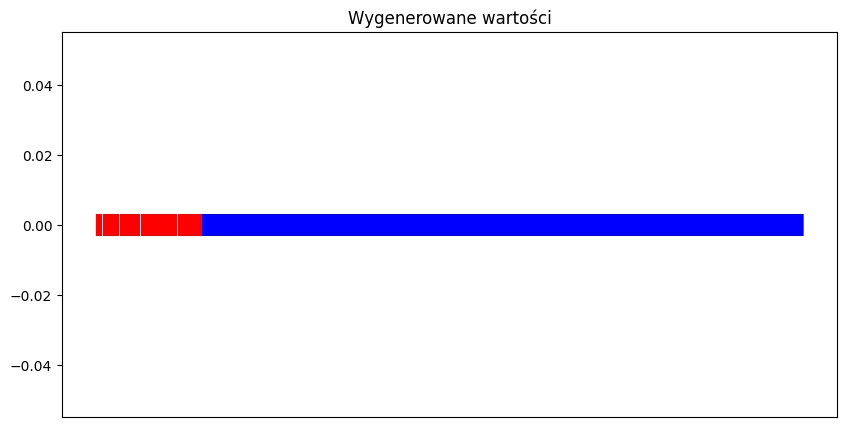

In [101]:
def plot_colored_nums(data, num_of_points, typical):
  fig, ax = plt.subplots(figsize=(10, 5))
  # ax.set_xlim(0, 10)
  # ax.set_ylim(0, 0.5)
  ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.set_title(f'Wygenerowane wartości')

  atypical_nums = sum(typical.values())

  plt.scatter(data, np.full(num_of_points, 0), marker='|', c='blue', s=250)
  for rand in data:
    if typical[rand] == 1:
      plt.scatter(rand, 0, marker='|', c='red', s=250)
  plt.show()

plot_colored_nums(test_sample[2], 1000, typical_arrs[2])

In [ ]:
def find_and_remove_atypical(data, cathegory, m, r):
    # temp = data[cathegory].copy()


    samples, _, gauss_to_original, _ = gauss_calc_df(data, cathegory, m)
    samples, hs = calculate_h_for_features(samples, m)
    clean = data[cathegory].copy()
    typical_arr = []

    for sample, h in zip(samples, hs):
        typical_vals = determine_if_typical(r, m, sample, h)
        typical_arr.append(typical_vals)

    i = 0
    for gauss_key, gauss_dict in gauss_to_original.items():
        for key, val in gauss_dict.items():
            if typical_arr[i][key] == 1:
                clean.drop(clean.index[clean[gauss_key] == val], axis=0, inplace=True)
        i += 1

    
    return data[cathegory], clean

In [108]:
slices = {}
cleans = {}
all_data = {}
years = [2020]#, 2022, 2023]

for i in range(1):
    temp = {}
    for name in crimes_categories_names:
        slice, clean = find_and_remove_atypical(split_years[i], name, 1000, 0.05)
        slices[name] = slice
        cleans[name] = clean
    temp['slices'] = slices
    temp['cleans'] = cleans
    all_data[years[i]] = temp

display(all_data)

{2020: {'slices': {'Abuse':         index  Date Rptd            DATE OCC  AREA    AREA NAME  Rpt Dist No  \
   0          17 2020-08-10 2020-01-01 00:01:00     4   Hollenbeck          429   
   1          18 2022-04-16 2020-01-01 00:01:00    20      Olympic         2054   
   2          40 2023-03-15 2020-01-01 00:01:00    13       Newton         1364   
   3          57 2020-09-02 2020-01-01 00:01:00    12  77th Street         1265   
   4          61 2020-08-21 2020-01-01 00:01:00    17   Devonshire         1764   
   ...       ...        ...                 ...   ...          ...          ...   
   46087  199777 2021-01-01 2020-12-31 23:40:00    15  N Hollywood         1555   
   46088  199781 2021-01-04 2020-12-31 23:50:00    15  N Hollywood         1532   
   46089  199782 2020-12-31 2020-12-31 23:50:00    18    Southeast         1829   
   46090  199783 2020-12-31 2020-12-31 23:55:00     5       Harbor          504   
   46091  199784 2020-12-31 2020-12-31 23:55:00     5       Ha

## 2020

In [109]:
cathegory = 'Other Crimes'
print(f'Before: {len(all_data[2020]["slices"][cathegory])} vs After: {len(all_data[2020]["cleans"][cathegory])}')

Before: 10386 vs After: 9837


In [110]:
display(all_data[2020]["slices"]['Abuse'])

,index,Date Rptd,DATE OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LOCATION,LAT,LON
0,17,2020-08-10,2020-01-01 00:01:00,4,Hollenbeck,429,626,INTIMATE PARTNER - SIMPLE ASSAULT,28,F,H,3700 LOWELL AV,34.0882,-118.1624
1,18,2022-04-16,2020-01-01 00:01:00,20,Olympic,2054,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",45,F,O,900 S NORMANDIE AV,34.0533,-118.3003
2,40,2023-03-15,2020-01-01 00:01:00,13,Newton,1364,626,INTIMATE PARTNER - SIMPLE ASSAULT,42,F,H,4600 HOOPER AV,33.9994,-118.2543
3,57,2020-09-02,2020-01-01 00:01:00,12,77th Street,1265,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,6,M,H,8200 S VERMONT AV,33.9655,-118.2918
4,61,2020-08-21,2020-01-01 00:01:00,17,Devonshire,1764,626,INTIMATE PARTNER - SIMPLE ASSAULT,33,F,H,9600 CORBIN AV,34.2446,-118.5623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46087,199777,2021-01-01,2020-12-31 23:40:00,15,N Hollywood,1555,625,OTHER ASSAULT,43,M,O,11100 OTSEGO ST,34.1630,-118.3709
46088,199781,2021-01-04,2020-12-31 23:50:00,15,N Hollywood,1532,624,BATTERY - SIMPLE ASSAULT,25,M,H,12300 OXNARD ST,34.1794,-118.4009
46089,199782,2020-12-31,2020-12-31 23:50:00,18,Southeast,1829,626,INTIMATE PARTNER - SIMPLE ASSAULT,24,F,H,97TH ST,33.9483,-118.2290
46090,199783,2020-12-31,2020-12-31 23:55:00,5,Harbor,504,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",24,M,H,TORRANCE,33.8416,-118.3040


In [128]:
def prepare_data_for_kmeans(clean):
    temp = clean.copy()
    x_tab = []
    cols = ['DATE OCC', 'LON', 'LAT']
    data_df = pd.DataFrame(columns=cols)

    for col in cols:
        data = temp[col].to_numpy()


        if col == 'DATE OCC':
            data = temp[col].dt.date.to_numpy()
            data = convert_date_to_numbers(data)
            
        x = np.linspace(np.min(data), np.max(data), len(data))

        data_df[col] = data
        x_tab.append(x)
    display(data_df)
    return data_df, x_tab

In [157]:
from sklearn.cluster import KMeans

def calculate_kmeans_3D(clean, n_clusters):
    data_df, _ = prepare_data_for_kmeans(clean)

    k_means = KMeans(n_clusters=n_clusters)
    k_means.fit(data_df)

    data_df['clusters'] = k_means.labels_

    return data_df, k_means.cluster_centers_

def calculate_kmeans_2D(clean, n_clusters, column_names=['LON', 'LAT']):
    data_df, _ = prepare_data_for_kmeans(clean)

    k_means = KMeans(n_clusters=n_clusters)
    k_means.fit(data_df[column_names])

    data_df['clusters'] = k_means.labels_

    return data_df, k_means.cluster_centers_

def calculate_kmeans_1D(clean, n_clusters, column_name='DATE OCC'):
    data_df, _ = prepare_data_for_kmeans(clean)

    k_means = KMeans(n_clusters=n_clusters)
    k_means.fit(data_df[column_name])

    data_col = pd.DataFrame()
    data_col[column_name] = data_df[column_name].copy()

    data_col['clusters'] = k_means.labels_

    return data_col, k_means.cluster_centers_

In [131]:
data_df, centers = calculate_kmeans_3D(all_data[2020]["cleans"]["Abuse"], 20)
display(data_df)

,DATE OCC,LON,LAT
0,0.0,-118.1624,34.0882
1,0.0,-118.3003,34.0533
2,0.0,-118.2543,33.9994
3,0.0,-118.2918,33.9655
4,0.0,-118.5623,34.2446
...,...,...,...
42067,365.0,-118.3709,34.1630
42068,365.0,-118.4009,34.1794
42069,365.0,-118.2290,33.9483
42070,365.0,-118.3040,33.8416


,DATE OCC,LON,LAT,clusters
0,0.0,-118.1624,34.0882,7
1,0.0,-118.3003,34.0533,7
2,0.0,-118.2543,33.9994,7
3,0.0,-118.2918,33.9655,7
4,0.0,-118.5623,34.2446,7
...,...,...,...,...
42067,365.0,-118.3709,34.1630,13
42068,365.0,-118.4009,34.1794,13
42069,365.0,-118.2290,33.9483,13
42070,365.0,-118.3040,33.8416,13


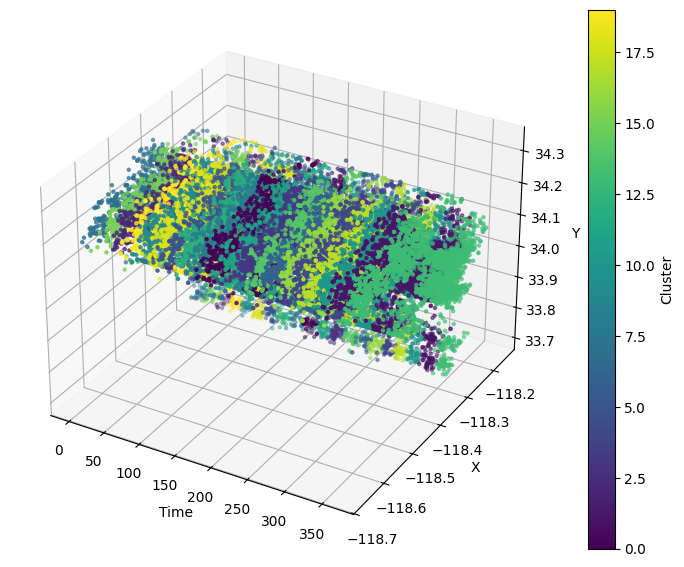

In [134]:
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_df['DATE OCC'], data_df['LON'], data_df['LAT'], c=data_df['clusters'], cmap='viridis', marker='.')

# Add labels and color bar
ax.set_xlabel('Time')
ax.set_ylabel('X')
ax.set_zlabel('Y')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

In [159]:
print(f'Cleans: {len(all_data[2020]["cleans"]["Abuse"])} vs DataDF {len(data_df)}')

Cleans: 42072 vs DataDF 42072


In [160]:
display(data_df)
display(all_data[2020]["cleans"]["Abuse"])

,DATE OCC,LON,LAT,clusters
0,0.0,-118.1624,34.0882,6
1,0.0,-118.3003,34.0533,19
2,0.0,-118.2543,33.9994,7
3,0.0,-118.2918,33.9655,0
4,0.0,-118.5623,34.2446,1
...,...,...,...,...
42067,365.0,-118.3709,34.1630,3
42068,365.0,-118.4009,34.1794,3
42069,365.0,-118.2290,33.9483,18
42070,365.0,-118.3040,33.8416,2


,index,Date Rptd,DATE OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LOCATION,LAT,LON
0,17,2020-08-10,2020-01-01 00:01:00,4,Hollenbeck,429,626,INTIMATE PARTNER - SIMPLE ASSAULT,28,F,H,3700 LOWELL AV,34.0882,-118.1624
1,18,2022-04-16,2020-01-01 00:01:00,20,Olympic,2054,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",45,F,O,900 S NORMANDIE AV,34.0533,-118.3003
2,40,2023-03-15,2020-01-01 00:01:00,13,Newton,1364,626,INTIMATE PARTNER - SIMPLE ASSAULT,42,F,H,4600 HOOPER AV,33.9994,-118.2543
3,57,2020-09-02,2020-01-01 00:01:00,12,77th Street,1265,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,6,M,H,8200 S VERMONT AV,33.9655,-118.2918
4,61,2020-08-21,2020-01-01 00:01:00,17,Devonshire,1764,626,INTIMATE PARTNER - SIMPLE ASSAULT,33,F,H,9600 CORBIN AV,34.2446,-118.5623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46087,199777,2021-01-01,2020-12-31 23:40:00,15,N Hollywood,1555,625,OTHER ASSAULT,43,M,O,11100 OTSEGO ST,34.1630,-118.3709
46088,199781,2021-01-04,2020-12-31 23:50:00,15,N Hollywood,1532,624,BATTERY - SIMPLE ASSAULT,25,M,H,12300 OXNARD ST,34.1794,-118.4009
46089,199782,2020-12-31,2020-12-31 23:50:00,18,Southeast,1829,626,INTIMATE PARTNER - SIMPLE ASSAULT,24,F,H,97TH ST,33.9483,-118.2290
46090,199783,2020-12-31,2020-12-31 23:55:00,5,Harbor,504,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",24,M,H,TORRANCE,33.8416,-118.3040


In [161]:
test_row = all_data[2020]["cleans"]["Abuse"]

def check_clusters(clean, data_df_clusters):
    data_df_clusters['correct'] = np.full(len(data_df_clusters), False)

    for (idx_clean, row_clean), (idx_data, row_data) in zip(clean.iterrows(), data_df_clusters.iterrows()):
        row_data['correct'] = row_clean['AREA'] == row_data['clusters']

    return data_df_clusters

In [164]:
data_df, centers = calculate_kmeans_2D(all_data[2020]["cleans"]["Abuse"], 20)
display(data_df)

,DATE OCC,LON,LAT
0,0.0,-118.1624,34.0882
1,0.0,-118.3003,34.0533
2,0.0,-118.2543,33.9994
3,0.0,-118.2918,33.9655
4,0.0,-118.5623,34.2446
...,...,...,...
42067,365.0,-118.3709,34.1630
42068,365.0,-118.4009,34.1794
42069,365.0,-118.2290,33.9483
42070,365.0,-118.3040,33.8416


,DATE OCC,LON,LAT,clusters
0,0.0,-118.1624,34.0882,9
1,0.0,-118.3003,34.0533,12
2,0.0,-118.2543,33.9994,18
3,0.0,-118.2918,33.9655,3
4,0.0,-118.5623,34.2446,6
...,...,...,...,...
42067,365.0,-118.3709,34.1630,7
42068,365.0,-118.4009,34.1794,7
42069,365.0,-118.2290,33.9483,19
42070,365.0,-118.3040,33.8416,2


In [165]:
data_df = check_clusters(test_row, data_df)

In [172]:
print(f'correct: {len(data_df[data_df["correct"] == True])} vs incorrect: {len(data_df[data_df["correct"] == False])}')

correct: 0 vs incorrect: 42072


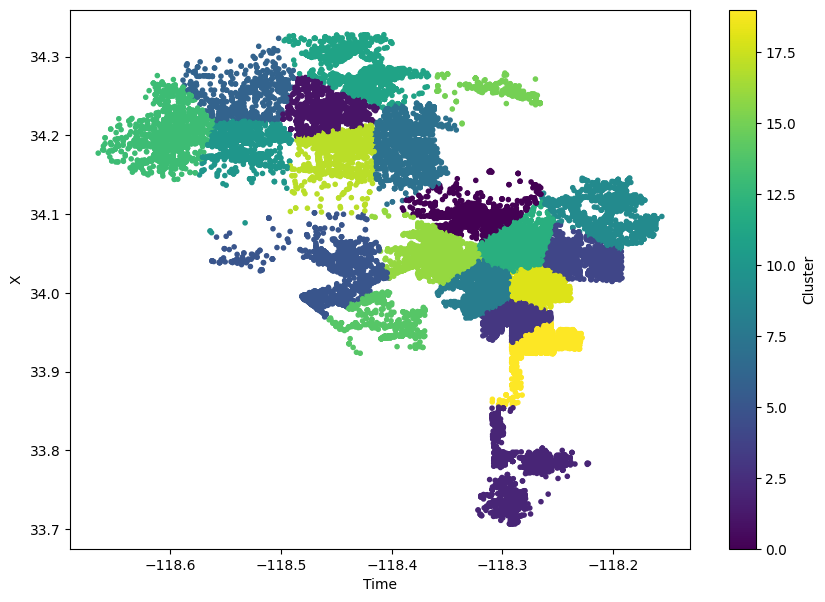

In [171]:
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(111)
scatter = ax.scatter(data_df['LON'], data_df['LAT'], c=data_df['clusters'], cmap='viridis', marker='.')

# Add labels and color bar
ax.set_xlabel('Time')
ax.set_ylabel('X')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()